### **Modularity**
--------------
The goal of this notebook is to test if we can apply the `w0` template to the rest of the coefficients `wi`.
We will perform the following steps:
- Define a smart synchronization function that extracts (200 samples) the `wi` according to its `wi_index` position into the power trace
- Perform a POIs shifting by applying this synchronization on the `w0`, and re-build the `w0` template
- Loop on the first 94 `wi` coefficients to test false negatives : for each `i`  position, a matching data set `Dilithium2_wi_to_0.ets` contains a `wi` equals to `0` 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from IPython.display import display
import scared
import estraces
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams["figure.figsize"] = (20,2)
vhex = np.vectorize(hex)

In [3]:
from ipywidgets import interact

##### **Load the data sets**
--------

In [5]:
ths_building = scared.traces.read_ths_from_ets_file('./dataset/profiling_hw_w0_v4.zip.ets')
ths_matching = scared.traces.read_ths_from_ets_file('./dataset/matching/Dilithium2_w2_to_0.ets')

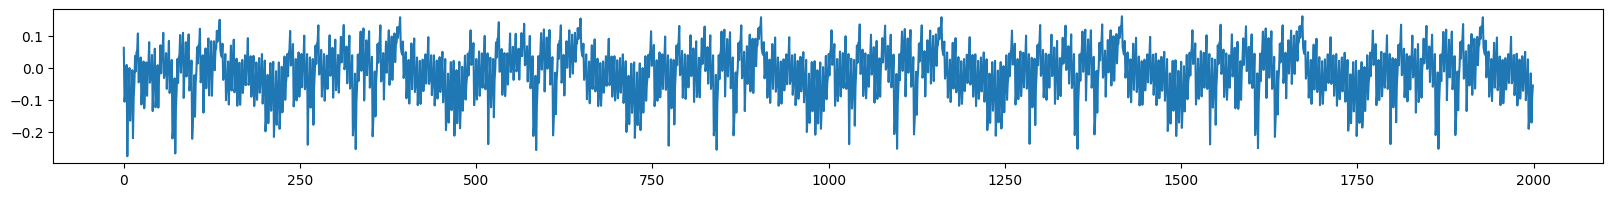

In [6]:
plt.plot(ths_matching.samples[0][:2000])
plt.show() 

##### **Select a singular pattern used for synchronization**
--------

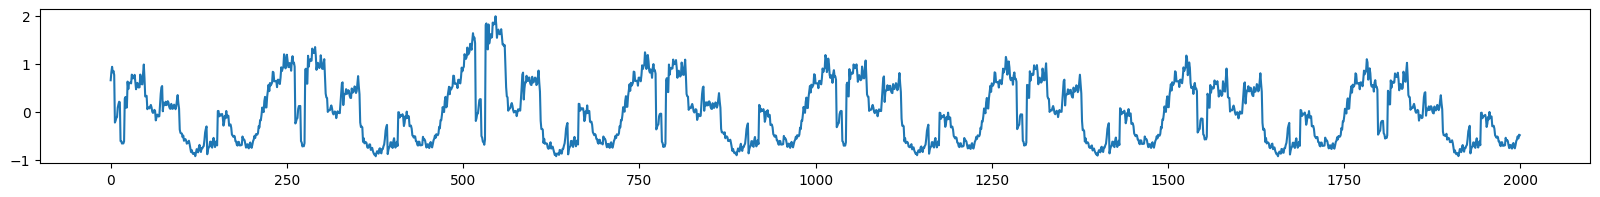

In [7]:
window_size = 50
moved = scared.signal_processing.moving_kurtosis(ths_matching.samples[0], window_size)
plt.plot(moved[:2000])
plt.show()

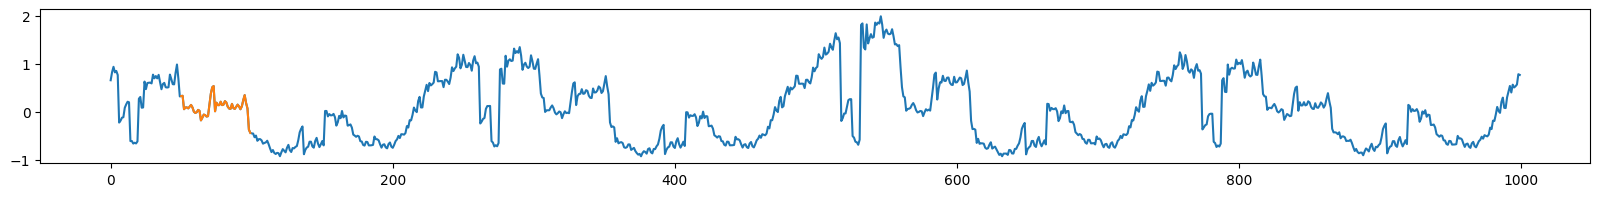

In [8]:
plt.plot(moved[:1000])
pattern = moved[50:100]
plt.plot(range(50,100), pattern)
plt.show()

##### **Define a synchronization function based on this pattern detection and trace extraction**
--------

In [9]:
def sync_func(trace_obj, pattern, frame=None, wi_index=0):
    #print(trace_obj)
    if frame is None:
        trace = trace_obj.samples[:]
    else:    
        trace = trace_obj.samples[frame]

    moved = scared.signal_processing.moving_kurtosis(trace, 50)
    distance = scared.signal_processing.pattern_detection.distance(trace=moved, pattern=pattern)

    peaks = scared.signal_processing.peaks_detection.find_peaks(-distance, 200, -100)
    extracted = scared.signal_processing.peaks_detection.extract_around_indexes(trace, indexes=peaks[wi_index], before=10, after=189, mode=scared.signal_processing.peaks_detection.ExtractMode.CONCATENATE)
    return extracted

extract = sync_func(ths_matching.traces[0], pattern, frame=None, wi_index = ths_matching[1].w0_index )


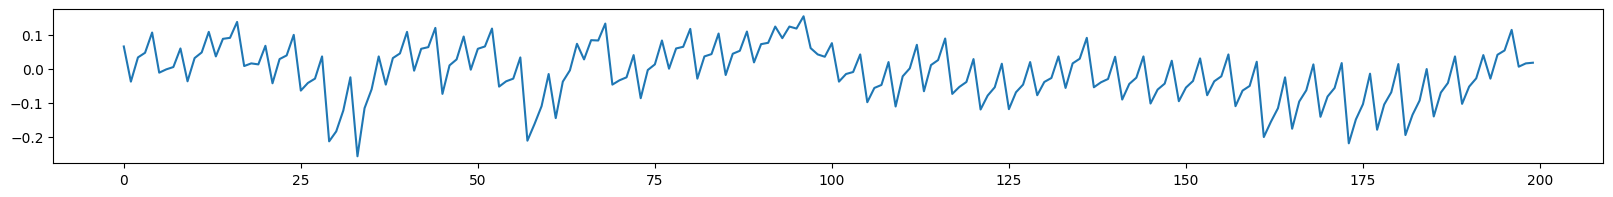

In [10]:
plt.plot(extract)
plt.show()

##### **Test the synchronization function on matching data set**
--------
In Dilithium2_w{i}_to_0.ets the w0_index contains the `w` positions where it is equals to 0

In [11]:
ths_matching

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ./dataset/matching/Dilithium2_w2_to_0.ets with 10 traces.
msg..............: uint8
w0...............: int32
w0_index.........: int32

In [12]:
ths_matching.w0_index[0]

array([2])

In [13]:
from tqdm import tqdm
sync_trace = []
for idx, trace in tqdm(enumerate(ths_matching)):
    t =sync_func(ths_matching.traces[idx],pattern, frame=None, wi_index = trace.w0_index)
    # check sync trace dimension
    if t.shape[0] != 200 :
        #t = np.append(t,[0]*(2600-t.shape[0]))
        print(t.shape)
    sync_trace.append(t[:])

10it [00:00, 212.08it/s]


In [14]:
ths_matching_ram = estraces.read_ths_from_ram(np.vstack(sync_trace), 
                                 msg=ths_matching.msg, w0=ths_matching.w0)

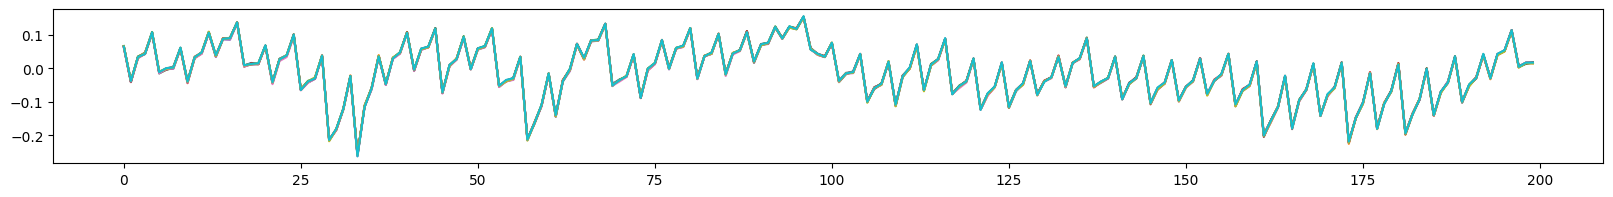

In [15]:
plt.plot(ths_matching_ram.samples[:100][:].T)
plt.show() 

##### **Synchronize the Building data set**
--------

In [16]:
from tqdm import tqdm
sync_trace = []
for idx, trace in tqdm(enumerate(ths_building)):
    t =sync_func(ths_building.traces[idx],pattern, frame=None, wi_index = np.array([0]))
    # check sync trace dimension
    if t.shape[0] != 200 :
        #t = np.append(t,[0]*(2600-t.shape[0]))
        print(t.shape)
    sync_trace.append(t[:])
    


25792it [15:02, 28.59it/s]


KeyboardInterrupt: 

In [26]:
ths_building_ram = estraces.read_ths_from_ram(np.vstack(sync_trace), 
                                 msg=ths_building.msg, w0=ths_building.w0, w0_hw=ths_building.w0_hw)

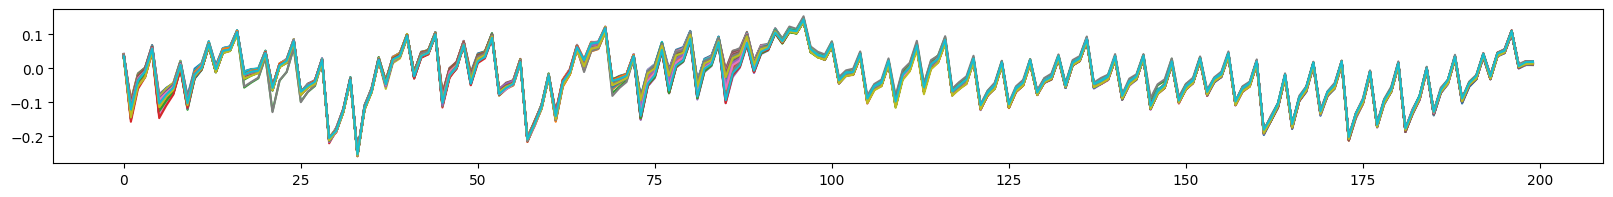

In [27]:
plt.plot(ths_building_ram.samples[:100][:].T)
plt.show() 

In [17]:
ets = estraces.ETSWriter('./dataset/profiling_hw_w0_v4_synchronized_v2.ets', overwrite=False)
ets.add_trace_header_set(ths_building_ram)

NameError: name 'ths_building_ram' is not defined

In [19]:
estraces.compress_ets('./dataset/profiling_hw_w0_v4_synchronized_v2.ets', './dataset/profiling_hw_w0_v4_synchronized_v2.zip.ets')

In [20]:
ths_building = estraces.read_ths_from_ets_file('./dataset/profiling_hw_w0_v4_synchronized_v2.zip.ets')

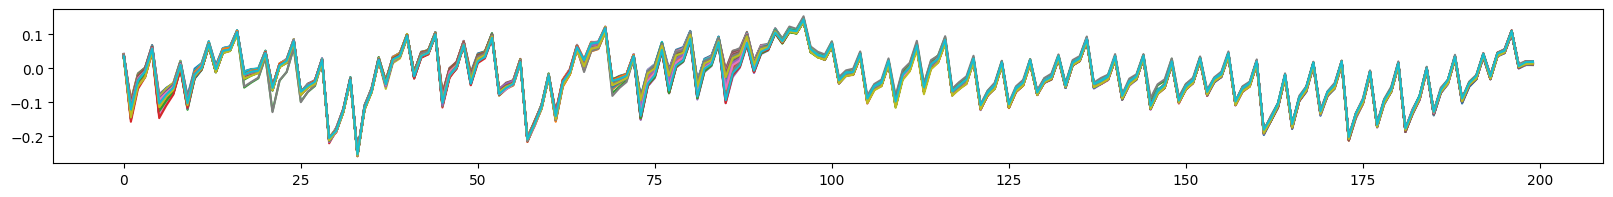

In [21]:
plt.plot(ths_building.samples[:100][:].T)
plt.show() 

#### **Reverse with ANOVA distinguisher**
----

In [22]:
def identity_w0(msg, w0):
    return w0

S = scared.reverse_selection_function(function=identity_w0)

In [23]:
ReverseANOVA = scared.ANOVAReverse(selection_function=S,
                                 model=scared.HammingWeight(),
                                 partitions = np.arange(9))

In [24]:
container = scared.Container(ths_building)

In [25]:
ReverseANOVA.run(container)

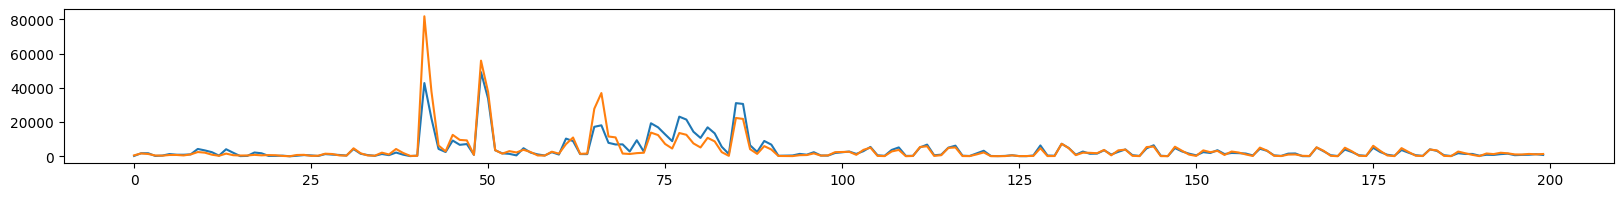

In [26]:
plt.plot(ReverseANOVA.results[2])
plt.plot(ReverseANOVA.results[3])
plt.show() 

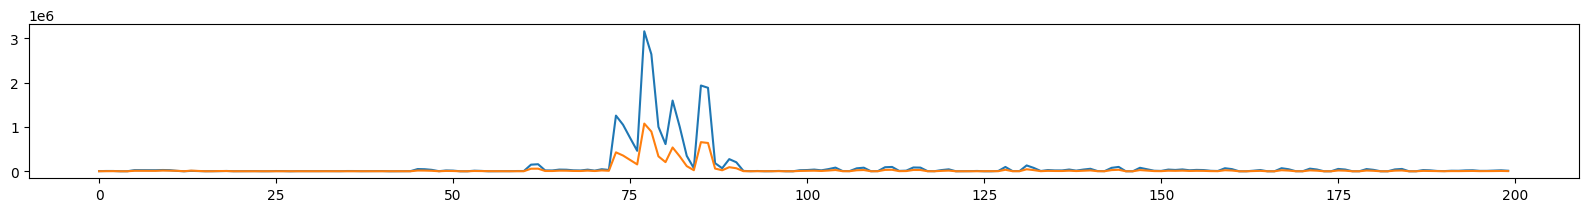

In [27]:
for i in range(0,2):
    plt.plot(ReverseANOVA.results[i])
plt.show()   

#### **POIs selection**
------

In [28]:
r = ReverseANOVA.results
pois = [np.argsort(r[word])[-5:] for word in range(4)]

@interact(word = (0, 3, 1))
def widget_pois(word=0):
    fg, ax = plt.subplots(figsize=(20, 4.5))
    ax.plot(ths_building.samples[:20, 0:200].T, alpha=0.19)
    ax2=ax.twinx()
    ax2.plot(r[word][0:200], color = "C0", alpha=1)
    #plt.plot(r[word])
    
    plt.plot(pois[word], r[word, pois[word]][0:200], 'C1+')
    #plt.xlim(6000, 10000)
    plt.title(f"POIs for word {word} (MSB to LSB order)")
    plt.show()

interactive(children=(IntSlider(value=0, description='word', max=3), Output()), _dom_classes=('widget-interact…

#### **Apply the `w0` template on the other coefficient position**
------
Perform the False negative test

In [29]:
from tqdm import tqdm

for i in tqdm(range(93)):
    ths_matching = scared.traces.read_ths_from_ets_file(f'./dataset/matching/Dilithium2_w{i}_to_0.ets')
    
    ##  Synchronize matching set
    sync_trace = []
    for idx, trace in enumerate(ths_matching):
        t =sync_func(ths_matching.traces[idx],pattern, frame=None, wi_index = trace.w0_index )
        # check sync trace dimension
        if t.shape[0] != 200 :
            #t = np.append(t,[0]*(2600-t.shape[0]))
            print(t.shape)
        sync_trace.append(t[:])

    ths_matching_ram = estraces.read_ths_from_ram(np.vstack(sync_trace), 
                             msg=ths_matching.msg, w0=ths_matching.w0)

    # Get the secret key to recover.
    ref = ths_matching_ram.w0[0]
    vhex(ref)
    
    ## Build template on building set (synchronized by sync_func) - same template, could be execute once...
    TAttacks = [scared.TemplateAttack(container_building=scared.Container(ths_building, frame = pois[word]),
                                      reverse_selection_function=scared.reverse_selection_function(function=identity_w0, words = word),
                                      model=scared.HammingWeight(),
                                      convergence_step=1,
                                      partitions = np.arange(9)) for word in range(0, 4)]        
    for T in TAttacks:
        T.build()
        
    for word in range(4):
        TAttacks[word].run (scared.Container(ths_matching_ram[:9], frame = pois[word]))

    K = np.array([T.scores.argmax(0).squeeze() for T in TAttacks], 'uint8')

    if np.array_equal(K, ref):
        # the wi = 0 is correctly detected
        continue
    else:
        print(f"'#{i}")
        print("The recovered key is: ", vhex(K))
        print("The secret key is:    ", vhex(ref))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [07:25<00:00,  4.79s/it]
